# 43008: Reinforcement Learning

## Week 5: Solving MDPs, Part-2 (for Gym based environments):
* Value Iteration Algorithm for Gym based environments
* Policy Iteration Algorithm for Gym based environmenmts

### What you will learn?
* Implement State Value Computation Algorithm
* Implement Policy Extraction Algorithm
* Implement Value Iteration Algorithm
* Implement Policy Evaluation Algorithm
* Implement Policy Improvement Algorithm
* Implement Policy Iteration Algorithm

### Let's install some important helper packages and libraries

In [ ]:
!pip install gymnasium pyvirtualdisplay
!apt-get install -y xvfb ffmpeg


### Import Libraries

In [ ]:
import gymnasium as gym
from gymnasium import wrappers
from gymnasium.wrappers import RecordVideo

import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

### Helper function for plotting the policy

In [ ]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np

# Define the function to plot the frozen lake with the given value function and policy
def plot_with_env(env, V, p, col_ramp=1, dpi=175, draw_vals=False):
    # Set the resolution of the plot
    plt.rcParams['figure.dpi'] = dpi
    # Set the color of the plot axes
    plt.rcParams.update({'axes.edgecolor': (0.32,0.36,0.38)})
    # Adjust font size based on the environment's grid size
    plt.rcParams.update({'font.size': 4 if env.unwrapped.nrow == 8 else 7})
    # Initialize a figure with a fixed size
    plt.figure(figsize=(3,3))
    # Display the value function as an image (darker means higher value)
    plt.imshow(1-np.array([V[s] for s in range(len(list(env.unwrapped.P.keys())))]).reshape(env.unwrapped.nrow,env.unwrapped.ncol)**col_ramp,
               cmap='gray', interpolation='none', clim=(0,1))

    # Get the current axes
    ax = plt.gca()
    # Set ticks for x and y axes
    ax.set_xticks(np.arange(env.unwrapped.ncol)-.5)
    ax.set_yticks(np.arange(env.unwrapped.nrow)-.5)
    # Remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Loop through each state in the environment
    for s in range(len(list(env.unwrapped.P.keys()))):
        # Calculate the x and y coordinates of the state
        x = s % env.unwrapped.ncol
        y = int(s / env.unwrapped.ncol)

        # Convert the policy action for the state to a one-hot encoded list
        a = [1 if i == p[s] else 0 for i in range(4)]

        # Set a gray color palette
        gray = np.array((0.32,0.36,0.38))

        # If the current state is the goal state
        if env.unwrapped.desc[y][x] == b'G':
            # Label it as 'goal'
            plt.text(x-0.45,y-0.3, 'goal', color=(0.75,0.22,0.17), fontname='DejaVu Sans', weight='bold')
            continue

        # Draw arrows based on the policy for each state
        # Arrow directions: left, down, right, up
        if a[0] > 0.0: plt.arrow(x, y, float(a[0])*-.84, 0.0, color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1)
        if a[1] > 0.0: plt.arrow(x, y, 0.0, float(a[1])*.84,  color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1)
        if a[2] > 0.0: plt.arrow(x, y, float(a[2])*.84, 0.0,  color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1)
        if a[3] > 0.0: plt.arrow(x, y, 0.0, float(a[3])*-.84, color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1)

        # Label 'ice' for frozen states
        if env.unwrapped.desc[y][x] == b'F': plt.text(x-0.45,y-0.3, 'ice', color=(gray*V[s]), fontname='DejaVu Sans')
        # Label 'start' for the starting state
        if env.unwrapped.desc[y][x] == b'S': plt.text(x-0.45,y-0.3, 'start',color=(0.21,0.51,0.48), fontname='DejaVu Sans', weight='bold')

        # If draw_vals is True, display the value of the state on the plot
        if draw_vals and V[s] > 0:
            vstr = '{0:.1e}'.format(V[s]) if env.unwrapped.nrow == 8 else '{0:.6f}'.format(V[s])
            plt.text(x-0.45,y+0.45, vstr, color=(gray*V[s]), fontname='DejaVu Sans')

    # Add a grid to the plot
    plt.grid(color=(0.42,0.46,0.48), linestyle=':')
    ax.set_axisbelow(True)
    # Set the color of the ticks
    ax.tick_params(color=(0.42,0.46,0.48),which='both',top='off',left='off',right='off',bottom='off')
    # Show the plot
    plt.show()

## Algorithms

### 1. Value Iteration



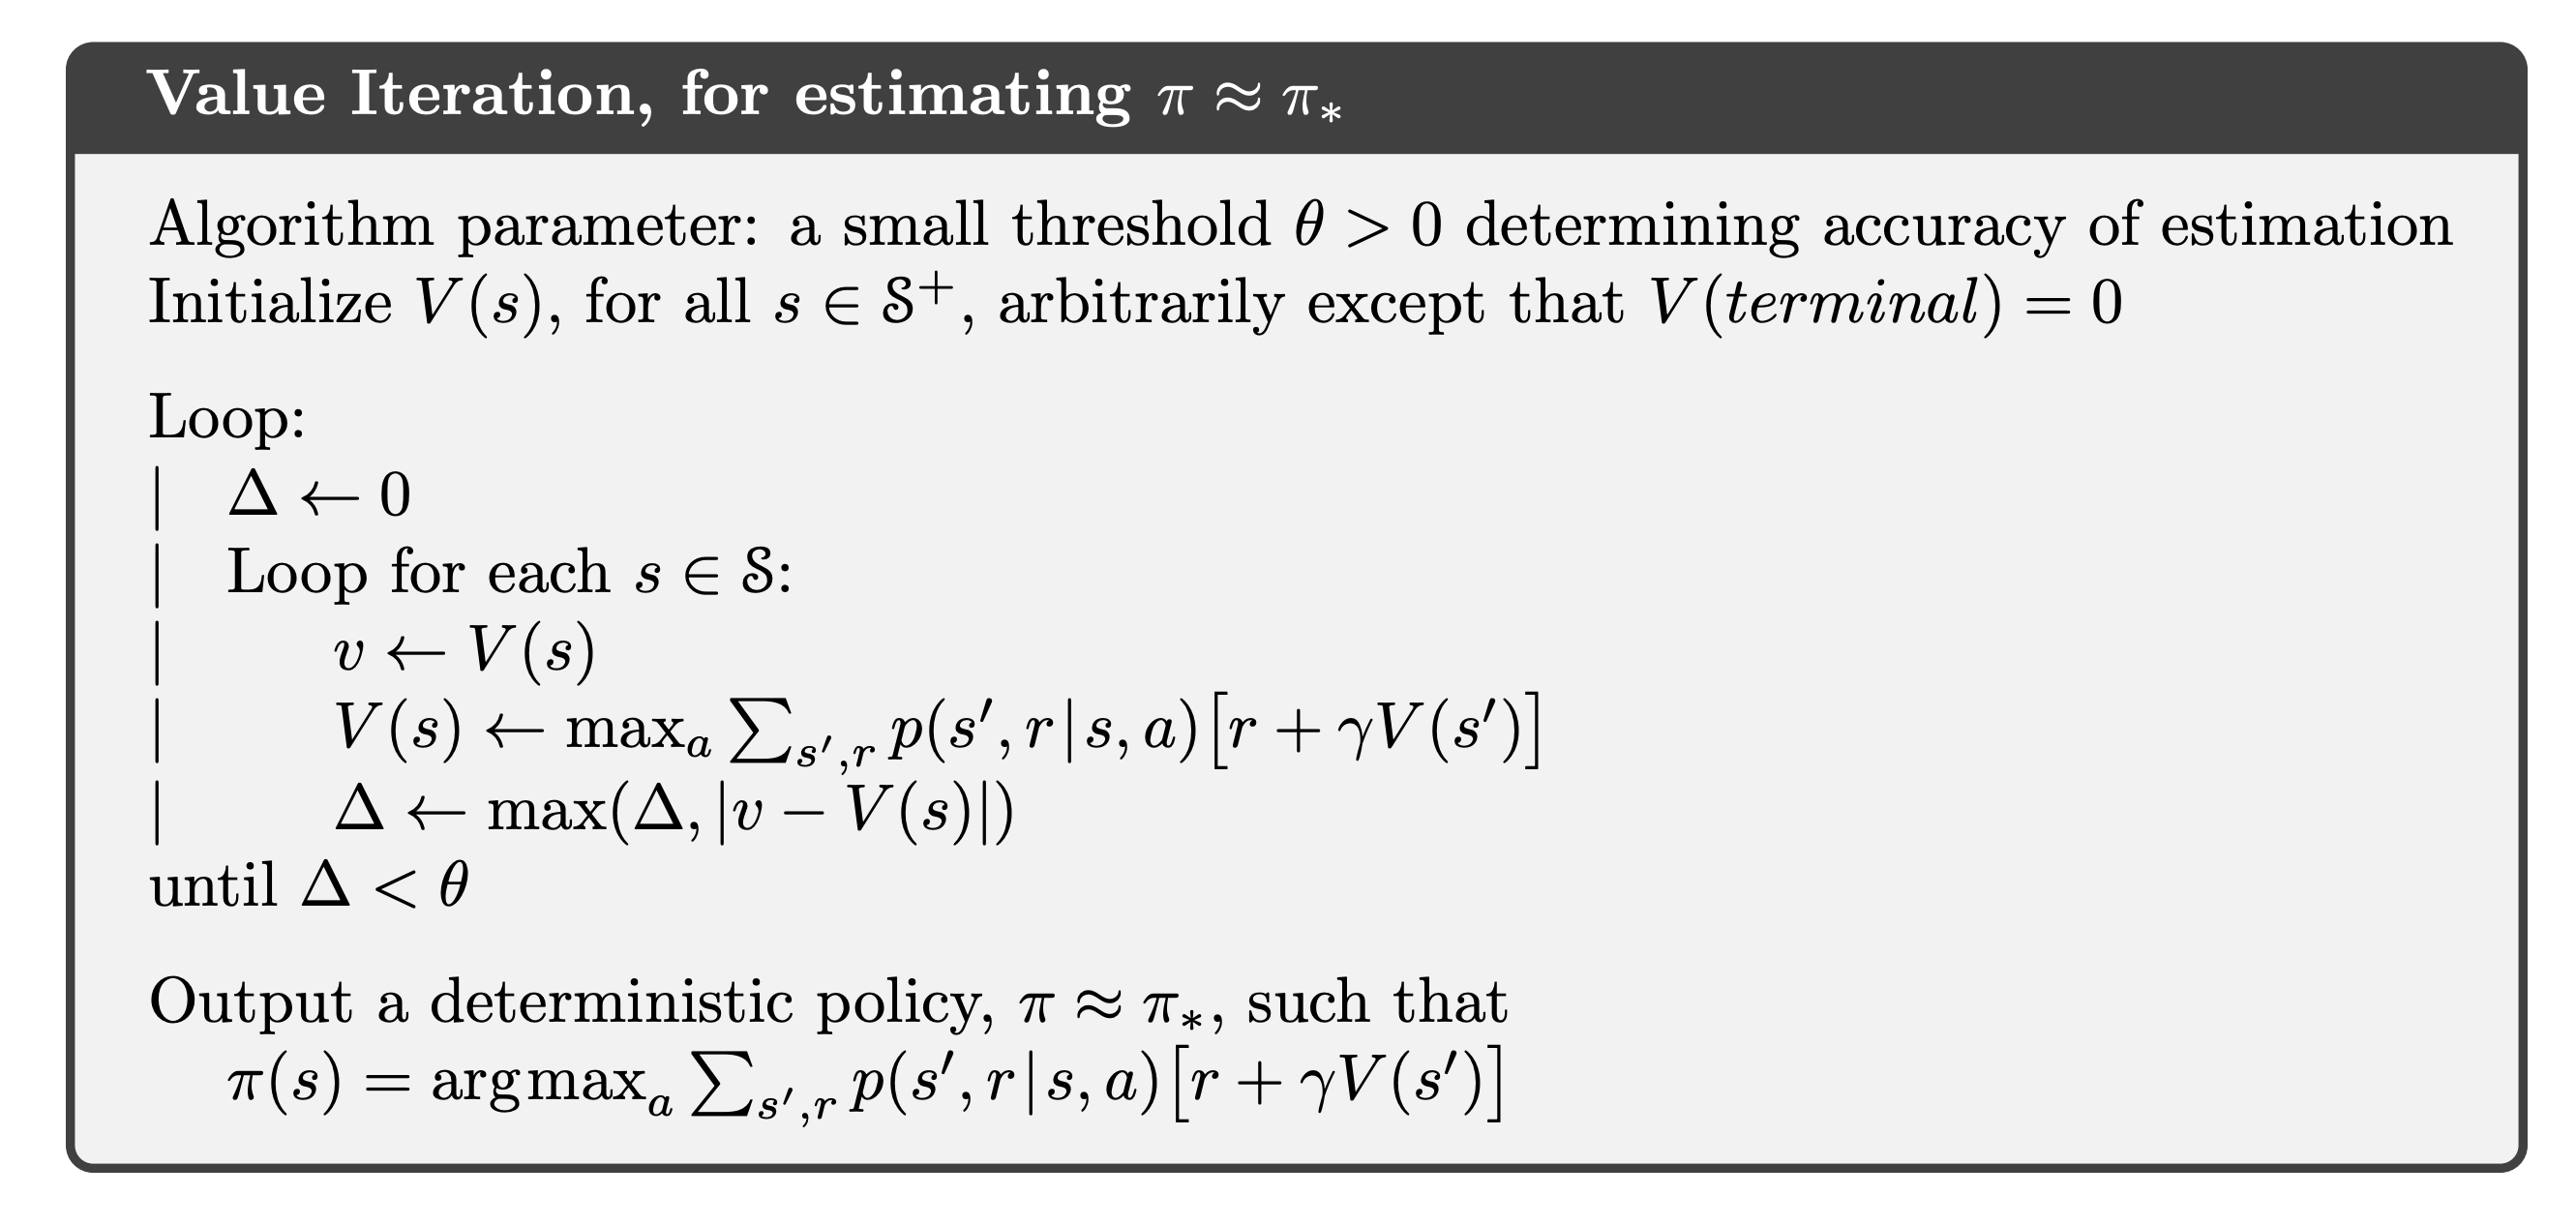



#### 1(a). State Value Computation using Bellman Optimality Equation

The state value for a given state $s$ can be computed using the Bellman Optimality Equation:


$$ v_*(s) = \max_a \sum_{s', r} p(s', r | s, a) \left[ r + \gamma v_*(s') \right] $$

Where:
- $v_*(s)$ is the optimal state-value of state $s$.
- $p(s', r | s, a)$ denotes the probability of transitioning to state $s'$ and receiving reward $r$ when action $a$ is taken in state $s$.
- $\gamma$ is the discount factor.

**Pseudo-code:**
```plain
Function ComputeStateValue(s, v, transition_probs, rewards, gamma):
    For each action a available in state s:
        For each possible next state s' and reward r:
            Calculate expected return using:
                Sum over transition_prob * (reward + gamma * value_of_next_state)
    Return the highest expected return among all actions
```



In [ ]:
# 1. compute_state_value
def compute_state_value_using_env(state, V, env, gamma):
    """
    Computes the value of a state using the Bellman optimality equation.

    Parameters:
    - state: Current state.
    - V: Current value function estimate.
    - env: gym environment.
    - gamma: Discount factor for future rewards.

    Returns:
    - Value of the state (V*(s)).
    """

    # List to store expected values for each action.
    expected_values = []

    # Iterate over each action available in the current state.
    for action in range(env.action_space.n):

        # Initialize the expected value for this action.
        action_value = 0

        # Calculate the expected value for the action by summing over all possible next states.
        for probability, next_state, reward, done in env.unwrapped.P[state][action]:

            # Update the action's expected value using the Bellman equation components.
            action_value += probability * (reward + gamma * V[next_state])

        # Append the expected value of the action to the list.
        expected_values.append(action_value)

    # Return the highest expected value among all actions.
    return max(expected_values)



#### 1(b). Policy Extraction based on Value Function

Policy Extraction is the process of determining the best action for each state based on a given state-value function $V$ using the Bellman optimality equation. The objective is to make the policy "greedy" with respect to the current value function.

Given a state $s$, the action chosen by the optimal policy $\pi^*$ is:

$$ \pi^*(s) = \arg\max_a \sum_{s'} p(s' | s, a) \left[ r + \gamma V(s') \right] $$

Where:
- $\pi^*(s)$ is the optimal policy's action for state $s$.
- $p(s' | s, a)$ denotes the transition probability to state $s'$ when action $ a$ is taken in state $s$.
- $\gamma$ is the discount factor.
- $r$ is the immediate reward for taking action $a$ in state $s$ and transitioning to $s'$.

**Pseudo-code**:
```
Function ExtractPolicy(V, transition_probs, rewards, actions, gamma):
    Initialize an empty policy
    For each state s:
        Initialize best_action to None and best_action_value to negative infinity
        For each action a available in state s:
            Initialize action_value to 0
            For each possible next state s':
                Update action_value using transition probabilities, rewards, and V
            If action_value is greater than best_action_value:
                Update best_action_value with action_value
                Update best_action with action a
        Update the policy for state s with best_action
    Return the policy
```

In [ ]:
# 2. extract_policy
def extract_policy_using_env(V, env, gamma):
    """
    Extracts the optimal policy based on a given value function using the Bellman optimality equation.

    Parameters:
    - V: Value function based on which policy is extracted.
    - env: gym environment.
    - gamma: Discount factor for future rewards.

    Returns:
    - Optimal policy (a mapping from states to optimal actions).
    """

    policy = {}

    # Construct the policy by iterating over each state.
    for state in range(env.observation_space.n):

        best_action_value = float('-inf')
        best_action = None

        # Evaluate each possible action to find the best one for this state.
        for action in range(env.action_space.n):

            action_value = 0  # Initialize the expected value for this action.

            # Compute the expected value for the state using this action.
            for probability, next_state, reward, done in env.unwrapped.P[state][action]:

                # Update the action's value using components of the Bellman equation.
                action_value += probability * (reward + gamma * V[next_state])

            # Update the best action if this action's value is higher.
            if action_value > best_action_value:
                best_action_value = action_value
                best_action = action

        # Update the policy for the current state with the best action.
        policy[state] = best_action

    return policy

#### 1(c). Value Iteration Algorithm

Value Iteration is a dynamic programming algorithm used to compute the optimal value function and, subsequently, the optimal policy for a given Markov Decision Process (MDP). The algorithm iteratively updates the value function until it converges and then extracts the policy based on this value function.

The core update equation used is the Bellman Optimality Equation:
$$ v_*(s) = \max_a \sum_{s', r} p(s', r | s, a) \left[ r + \gamma v_*(s') \right] $$

Where:
- $v_*(s)$ is the optimal state-value of state $s$.
- $p(s', r | s, a)$ denotes the transition probability to state $s'$ and receiving reward $r$ when action $a$ is taken in state $s$.
- $\gamma$ is the discount factor.

**Pseudo-code**:
```plain
Function ValueIteration(states, actions, transition_probs, rewards, gamma, eps):
    Initialize V for each state to 0
    Repeat:
        new_V = V.copy()
        For each state:
            Update new_V[state] using Bellman Optimality Equation
        If max change between new_V and V < eps:
            Break
        V = new_V
    Extract policy based on V using the policy extraction method
    Return V, policy
```


In [ ]:
# 3. value_iteration
def value_iteration_using_env(env, gamma=0.9, theta=1e-3, debug_print=False):
    """
    Implements the value iteration algorithm to find the optimal policy and value function.

    Parameters:
    - env: gym environment.
    - gamma: Discount factor for future rewards.
    - theta: Convergence threshold. Stops value iteration when the change in value function is smaller than theta.
    - debug_print: Flag to print debug information.

    Returns:
    - V: Optimal value function.
    - policy: Optimal policy.
    """

    # Initialization of the value function.
    V = {state: 0 for state in range(env.observation_space.n)}
    iteration = 0

    while True:
        new_V = V.copy()
        delta = 0

        # Value Update for each state.
        for state in range(env.observation_space.n):
            new_V[state] = compute_state_value_using_env(state, V, env, gamma)
            delta = max(delta, abs(new_V[state] - V[state]))

        # Optional: Print debug information.
        if debug_print:
            iteration += 1
            print(f"Value Iteration {iteration}: Max Change: {delta}, Value Function: {new_V}")

        # Convergence Check.
        if delta < theta:
            break

        V = new_V

    # Policy Extraction using the optimal value function.
    policy = extract_policy_using_env(V, env, gamma)
    plot_with_env(env, V, policy, draw_vals=True)
    return V, policy


### 2. Policy Iteration

**Idea**: Start with an intial policy and iteratively update the policy to find the best one

**It has two steps:**

**Step 1:** Policy Evaluation: Evaluate a given policy

**Step 2:** Policy Improvement: Refine or find a better policy


#### 2(a). Policy Evaluation

Policy Evaluation is a process that estimates the state-value function $v_\pi$ for a given policy $\pi$ in a Markov Decision Process (MDP). It uses the Bellman expectation equation for policy evaluation:

$$ v_\pi(s) = \sum_{a \in A} \pi(a|s) \sum_{s', r} p(s', r | s, a) \left[ r + \gamma v_\pi(s') \right] $$

However, for deterministic policies, where each state $s$ has a specific action $a$ defined by the policy $\pi$, the equation simplifies to:

$$ v_\pi(s) = \sum_{s', r} p(s', r | s, \pi(s)) \left[ r + \gamma v_\pi(s') \right] $$

Where:
- $v_\pi(s)$ is the state-value of state $s$ under policy $\pi$.
- $p(s', r | s, a)$ is the probability of transitioning to state $s'$ and receiving reward $r$ when action $a$ is taken in state $s$.
- $\gamma$ is the discount factor.

#### Algorithm

<img src='https://drive.google.com/uc?id=1w8IDWm9ouH9EOrwgfw1hyFgeDzlwdIoZ' height=300>


**Pseudo-code**:
```plain
Function PolicyEvaluation(policy, transition_probs, rewards, gamma, eps):
    Initialize V for each state to 0
    Repeat:
        new_V = copy of V
        For each state s:
            action = policy's action for state s
            state_value = 0
            For each possible next state s' and corresponding reward r:
                Calculate expected value for s' using transition probabilities and rewards
                Update state_value using the calculated expected value
            Update new_V for state s with state_value
        If max change between new_V and V < eps:
            Break
        V = new_V
    Return V
```

In [ ]:
# 4. policy_evaluation
def policy_evaluation_using_env(policy, env, gamma, theta):
    """
    Evaluate the value function of a given policy using the Bellman expectation equation.

    Parameters:
    - policy: The policy to be evaluated.
    - env: gym environment.
    - gamma: Discount factor for future rewards.
    - theta: Convergence threshold. Stops evaluation once value function changes are smaller than theta.

    Returns:
    - V: Value function of the given policy (v_pi).
    """

    # Initialization: Start with an arbitrary value function.
    V = {state: 0 for state in range(env.observation_space.n)}

    while True:
        new_V = V.copy()
        delta = 0

        # Update each state's value based on the Bellman expectation equation.
        for state in range(env.observation_space.n):

            # Given the deterministic policy, we directly get the action for the state.
            action = policy[state]
            state_value = 0

            # Compute the expected value for the state using its policy action.
            for probability, next_state, reward, done in env.unwrapped.P[state][action]:
                state_value += probability * (reward + gamma * V[next_state])

            # Assign the computed state value to the new value function.
            new_V[state] = state_value
            delta = max(delta, abs(new_V[state] - V[state]))

        # Convergence Check.
        if delta < theta:
            break

        # Update the value function for the next iteration.
        V = new_V

    return V

#### 2(b). Policy Improvement

Policy Improvement is a process used to refine or enhance an existing policy based on a given state-value function $V$. The objective is to make the policy "greedy" with respect to the current value function, ensuring that at each state, the action that maximizes the expected return, based on the current value function, is chosen.

The core formula used to select the optimal action for a state $s$ is:

$$ \pi'(s) = \arg\max_a \sum_{s', r} p(s', r | s, a) \left[ r + \gamma V(s') \right] $$

Where:
- $\pi'(s)$ is the improved policy's action for state $s$.
- $p(s', r | s, a)$ denotes the transition probability to state $s'$ and receiving reward $r$ when action $a$ is taken in state $s$.
- $\gamma$ is the discount factor.

**Pseudo-code**:
```plain
Function PolicyImprovement(V, transition_probs, rewards, actions, gamma):
    Initialize an empty policy new_policy
    For each state s:
        Initialize best_action to None and best_value to negative infinity
        For each action a available in state s:
            Initialize action_value to 0
            For each possible next state s' and corresponding reward r:
                Calculate expected value for s' based on transition probabilities, rewards, and V
                Update action_value with the calculated expected value
            If action_value is greater than best_value:
                Update best_value with action_value
                Update best_action with action a
        Update new_policy for state s with best_action
    Return new_policy
```


In [ ]:
# 5. policy_improvement
def policy_improvement_using_env(V, env, gamma):
    """
    Performs policy improvement using a given value function.

    Parameters:
    - V: Current value function estimate.
    - env: gym environment.
    - gamma: Discount factor for future rewards.

    Returns:
    - policy: Updated policy based on the given value function.
    """

    # Dictionary to store the updated policy for each state.
    policy = {}

    # Iterate over each state in the environment.
    for state in range(env.observation_space.n):

        # List to store the value of each action for the current state.
        action_values = []

        # Calculate the value for each action in the current state.
        for action in range(env.action_space.n):
            action_value = 0  # Initialize the expected value for this action.

            # Compute the expected value for the action by summing over all possible next states.
            for probability, next_state, reward, done in env.unwrapped.P[state][action]:

                # Update the action's value using components of the Bellman equation.
                action_value += probability * (reward + gamma * V[next_state])

            # Append the expected value of the action to the list.
            action_values.append(action_value)

        # Update the policy for the current state with the action that has the highest value.
        policy[state] = action_values.index(max(action_values))

    return policy

#### 2(c). Policy Iteration Algorithm

Policy Iteration is a two-step process used to determine the optimal policy and the associated state-value function in a Markov Decision Process (MDP). The algorithm alternates between **Policy Evaluation** and **Policy Improvement** until the policy converges to the optimal policy.

1. **Policy Evaluation**: Compute the state-value function $v_\pi$ for the current policy $\pi$ using the Bellman expectation equation:

$$ v_\pi(s) = \sum_{a \in A} \pi(a|s) \sum_{s', r} p(s', r | s, a) \left[ r + \gamma v_\pi(s') \right] $$

2. **Policy Improvement**: Update the policy by making it "greedy" with respect to the current state-value function:

$$ \pi'(s) = \arg\max_a \sum_{s', r} p(s', r | s, a) \left[ r + \gamma v_\pi(s') \right] $$

The process is repeated until the policy remains unchanged after an improvement step, indicating convergence to the optimal policy.

**Pseudo-code**:
```plain
Function PolicyIteration(states, actions, transition_probs, rewards, gamma, eps):
    Initialize an arbitrary policy (e.g., the first available action for each state)
    Repeat:
        Evaluate the current policy to get the state-value function V
        Improve the policy based on V to get new_policy
        If new_policy is the same as the current policy:
            Break
        Update the current policy to new_policy
    Return the final state-value function V and the optimal policy
```

In [ ]:
# 6. policy_iteration
def policy_iteration_using_env(env, gamma=0.9, theta=1e-3, debug_print=False):
    """
    Implements the policy iteration algorithm to find the optimal policy and value function.

    Parameters:
    - env: gym environment.
    - gamma: Discount factor for future rewards.
    - theta: Convergence threshold. Stops policy iteration when the policy remains unchanged.
    - debug_print: Flag to print debug information.

    Returns:
    - V: Optimal value function.
    - policy: Optimal policy.
    """

    # Initialize policy arbitrarily for each state.
    policy = {state: 0 for state in range(env.observation_space.n)}
    iteration_count = 0

    while True:
        iteration_count += 1

        # Evaluate the current policy to get its value function.
        V = policy_evaluation_using_env(policy, env, gamma, theta)

        # Optional: Print the value function after policy evaluation.
        if debug_print:
            print(f"Policy Iteration {iteration_count}: Value Function after Policy Evaluation: {V}")

        # Improve the policy using the computed value function.
        new_policy = policy_improvement_using_env(V, env, gamma)

        # Optional: Print the updated policy after policy improvement.
        if debug_print:
            print(f"Policy Iteration {iteration_count}: Policy after Improvement: {new_policy} \n")

        # Check for policy convergence: If the policy remains unchanged, stop the iteration.
        if new_policy == policy:
            break

        # Update the policy for the next iteration.
        policy = new_policy
        plot_with_env(env, V, policy, draw_vals=True)
    return V, policy

### Helper function for visualisation

In [ ]:
def simulate_and_show_video(env, p):
    """
    Simulate an environment using a given policy and display the video.

    Parameters:
    - env: The environment to simulate.
    - p: The policy to use for taking actions.

    Returns:
    - HTML object if video was captured, or a message indicating no videos were found.
    """

    # Create a video recorder for the environment, saving the video as 'video.mp4'
    recorder = RecordVideo(env, video_folder='./', name_prefix='video')


    # Reset the environment to its initial state
    state, info = recorder.reset()
    done = False

    # Keep simulating the environment until it's done
    while not done:
        # Select an action based on the current state and the given policy
        action = p[state] # Access the state directly


        # Take a step in the environment using the selected action
        # The step method returns:
        # - observation (state): The new state of the environment after taking the action
        # - reward: The reward obtained by taking the action
        # - terminated: A boolean indicating if the environment has reached a terminal state
        # - truncated: A boolean indicating if the episode was truncated (e.g. max steps reached)
        # - info: A dictionary with auxiliary diagnostic or debugging information
        state, reward, terminated, truncated, info = recorder.step(action)
        done = terminated or truncated


    # Close the video recorder
    recorder.close()

    # Close the environment
    env.close()

    # Look for the '.mp4' files in the current directory
    mp4list = glob.glob('*.mp4')

    # If there are any .mp4 files
    if len(mp4list) > 0:
        # Select the first .mp4 file
        mp4 = mp4list[0]

        # Read the video file
        video = io.open(mp4, 'r+b').read()

        # Encode the video in base64 format
        encoded = base64.b64encode(video)

        # Return an HTML video tag to display the video
        return HTML(data='''<video alt="test" autoplay
                       loop controls style="height: 400px;">
                       <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii')))
    else:
        # If no .mp4 files were found, return a message
        return "No videos found"



##**3. Scenario: Frozen Lake**





### Initialise Environment


![Frozen Lake GIF](https://www.gymlibrary.dev/_images/frozen_lake.gif)

# Frozen Lake

[Source](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/)

This environment is part of the Toy Text environments. Please read that page first for general information.

## Action Space
- Type: `Discrete(4)`
- The agent takes a 1-element vector for actions. The action space is `(dir)`, where `dir` decides the direction to move in:
  - `0`: LEFT
  - `1`: DOWN
  - `2`: RIGHT
  - `3`: UP

## Observation Space
- Type: `Discrete(16)`
- The observation is a value representing the agent’s current position as `current_row * nrows + current_col` (where both the row and col start at 0). For example, the goal position in the 4x4 map can be calculated as follows: `3 * 4 + 3 = 15`. The number of possible observations depends on the size of the map. For example, the 4x4 map has 16 possible observations.

## Rewards
- Reach goal(G): `+1`
- Reach hole(H): `0`
- Reach frozen(F): `0`

## Import
```python
gym.make("FrozenLake-v1")
```

## Arguments
```python
gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
```

## Description
Frozen lake involves crossing a frozen lake from Start (S) to Goal (G) without falling into any Holes (H) by walking over the Frozen (F) lake. The agent may not always move in the intended direction due to the slippery nature of the frozen lake.

In [ ]:
# Initialize the FrozenLake environment (non-slippery)
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode='rgb_array')


# Initialize the FrozenLake 8x8 environment (non-slippery)
# env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False, render_mode='rgb_array')


# Initialize the Taxi environment
# env = gym.make("Taxi-v3", render_mode='rgb_array')

### Solve MDP using Policy Iteration and visualise:

In [ ]:
# Execute Policy Iteration Algorithm
V, policy = policy_iteration_using_env(env, debug_print=True)

# Display outcomes
print("\n Policy Iteration: Value function: ", V)
print("Policy Iteration: Policy: ", policy)

In [ ]:
simulate_and_show_video(env, policy)

### Solve MDP using Value Iteration and visualise:

In [ ]:
v, p = value_iteration_using_env(env, debug_print=True)
print("Value Iteration: Value function: ", v)
print("Value Iteration: Policy: ", p)

In [ ]:
simulate_and_show_video(env, p)

---